# 02_Preprocesamiento.ipynb

## 📑 Índice
1. Introducción
2. Carga de dataset filtrado
3. Estrategia de imputación
   - Justificación del método
   - Variables a imputar
4. Implementación de imputación
   - Forward-fill / Interpolación
   - KNN Imputer (si aplica)
5. Normalización y escalado
6. Generación de variables derivadas
   - Rolling mean / std
   - Lag features
7. Exportación de dataset final
8. Conclusiones


In [33]:
# Importar librerías
import pandas as pd
import numpy as np

# Cargar dataset filtrado (alta + media calidad)
df = pd.read_csv("../data/processed/df_filtrado.csv")

# Vista rápida
print("Shape:", df.shape)
print("Columnas:", df.columns.tolist())
df.head()


Shape: (133583, 13)
Columnas: ['WELL_ID', 'DATE', 'CURRENT', 'PRESS_DESC', 'FREQUENCY', 'PRESS_INT', 'TEMP_INT', 'TEMP_MOT', 'OUT_VOLT', 'VIBRATION', 'PRESS_INTK', 'TEMP_INTK', 'WellFailure']


C:\Users\Vìctor\AppData\Local\Temp\ipykernel_1552\3380516470.py:6: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/processed/df_filtrado.csv")


,WELL_ID,DATE,CURRENT,PRESS_DESC,FREQUENCY,PRESS_INT,TEMP_INT,TEMP_MOT,OUT_VOLT,VIBRATION,PRESS_INTK,TEMP_INTK,WellFailure
0,DEEPWATER-VVBMZ0,2020-01-01 00:00:00,4.480000,2659.0600,0.550000,NaN,NaN,105.570000,0.00000,2.550000,1966.8,80.64,yes
1,DEEPWATER-VKCG0Y,2020-01-01 08:00:31,24.799999,4172.1997,54.000000,460.50000,235.399990,279.099980,425.10001,0.200136,NaN,NaN,NaN
2,DEEPWATER-BPUSBG,2020-01-01 08:03:01,62.700001,4226.0996,56.000000,537.20001,228.000000,282.699980,426.60001,0.300204,NaN,NaN,NaN
3,DEEPWATER-TXV4MX,2020-01-01 08:03:47,39.000000,0.0000,55.400002,0.00000,-0.000003,-0.000003,NaN,0.000000,NaN,NaN,NaN
4,DEEPWATER-EU2FJA,2020-01-01 08:03:50,50.599998,3906.7000,56.500000,806.00000,230.899990,282.899990,467.79999,1.100747,NaN,NaN,NaN


## 📊 Análisis y tratamiento de valores nulos

En esta sección se revisa la cantidad de valores faltantes en el dataset y se aplican
dos estrategias de imputación:

1. **Interpolación temporal (por pozo):**  
   Adecuada para variables continuas de series temporales, ya que aprovecha la tendencia de los sensores.

2. **KNN Imputer (scikit-learn):**  
   Imputa valores considerando la similitud entre registros multivariados.  
   Puede ser más robusto cuando existen correlaciones fuertes entre variables.

El objetivo es comparar ambos métodos y seleccionar el más adecuado para el modelado.


In [34]:
import pandas as pd

# Este es el dataset definitivo de entrada al preprocesamiento
df = pd.read_csv("../data/processed/df_filtrado.csv")

print("Dataset cargado. Shape:", df.shape)



Dataset cargado. Shape: (133583, 13)


C:\Users\Vìctor\AppData\Local\Temp\ipykernel_1552\733992502.py:4: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/processed/df_filtrado.csv")


In [35]:
# Conteo de nulos por variable
nulos_totales = df.isna().sum().sort_values(ascending=False)
nulos_porcentaje = (df.isna().mean() * 100).sort_values(ascending=False)

resumen_nulos = pd.DataFrame({
    "Nulos": nulos_totales,
    "% Nulos": nulos_porcentaje.round(2)
})

print("📊 Resumen de valores nulos:")
display(resumen_nulos)


📊 Resumen de valores nulos:


,Nulos,% Nulos
TEMP_INTK,133582,100.00
PRESS_INTK,133582,100.00
WellFailure,133574,99.99
OUT_VOLT,61226,45.83
VIBRATION,35357,26.47
CURRENT,18859,14.12
TEMP_INT,18448,13.81
TEMP_MOT,10515,7.87
PRESS_DESC,8136,6.09
PRESS_INT,7417,5.55


## 🔴 Identificación de shutdowns

Los registros con `CURRENT=0`, `FREQUENCY=0` y `PRESS_DESC=0` fueron clasificados como **Shutdown**.  
Este etiquetado es importante porque:
- Antes del shutdown pueden aparecer anomalías que sirven como predictores de falla.  
- Durante el shutdown los valores de sensores reflejan estados por defecto y no deben confundirse con operación real.  
- Después del restart se pueden analizar patrones de recuperación o arranques fallidos.  


Estado
Operativo    130614
Shutdown       2969
Name: count, dtype: int64


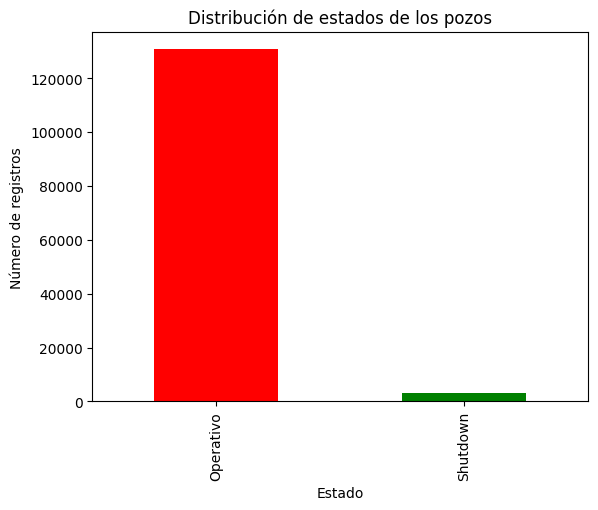

In [36]:
# Crear columna Estado
def detectar_shutdown(row):
    if (row["CURRENT"] == 0) and (row["FREQUENCY"] == 0) and (row["PRESS_DESC"] == 0):
        return "Shutdown"
    else:
        return "Operativo"

df["Estado"] = df.apply(detectar_shutdown, axis=1)

# Conteo de estados
print(df["Estado"].value_counts())

# Visualización rápida
import matplotlib.pyplot as plt

df["Estado"].value_counts().plot(kind="bar", color=["red", "green"])
plt.title("Distribución de estados de los pozos")
plt.ylabel("Número de registros")
plt.show()


## 📊 Segmentación de pozos por estados

Además de clasificar cada registro como **Operativo** o **Shutdown**,  
se segmentaron los pozos según su historial:

- **Siempre operativo:** pozos que nunca presentaron registros de apagado.  
- **Con shutdowns:** pozos que al menos una vez estuvieron en estado de apagado.  

Esta clasificación permite analizar no solo los registros individuales,  
sino también el comportamiento histórico de cada pozo.



In [37]:
# Estado por pozo: ¿cuántos shutdowns tiene cada pozo?
estado_pozos = (
    df.groupby("WELL_ID")["Estado"]
      .apply(lambda x: (x == "Shutdown").sum())
      .reset_index(name="Shutdowns")
)

# Clasificación
def clasificar_pozo(n_shutdowns):
    if n_shutdowns == 0:
        return "Siempre operativo"
    else:
        return "Con shutdowns"

estado_pozos["Categoria"] = estado_pozos["Shutdowns"].apply(clasificar_pozo)

print("📊 Resumen de pozos por categoría:")
print(estado_pozos["Categoria"].value_counts())

estado_pozos.head()


📊 Resumen de pozos por categoría:
Categoria
Siempre operativo    36
Con shutdowns        21
Name: count, dtype: int64


,WELL_ID,Shutdowns,Categoria
0,DEEPWATER-000XAR,0,Siempre operativo
1,DEEPWATER-0KPXEZ,0,Siempre operativo
2,DEEPWATER-0SSSKO,0,Siempre operativo
3,DEEPWATER-1AD32W,5,Con shutdowns
4,DEEPWATER-1UBHZV,0,Siempre operativo


## 📊 Gobernanza de datos sobre shutdowns en ESP

El análisis de 57 pozos con datos de sensores permitió identificar dos categorías:

- **36 pozos (63%)** → Sin historial de apagados (operación estable).  
- **21 pozos (37%)** → Con eventos de shutdown registrados.  

### 📌 Implicaciones gerenciales
- Los pozos **siempre operativos** representan activos confiables y pueden considerarse como **benchmarks de buenas prácticas operativas**.  
- Los pozos **con shutdowns** requieren **planes de mantenimiento predictivo** y análisis de causa raíz para evitar recurrencias.  
- Esta clasificación habilita un **tablero de control de gobernanza de datos** para priorizar intervenciones, asignar recursos y reducir pérdidas productivas.  

El resultado muestra cómo la analítica de datos en tiempo real puede servir como herramienta de **gestión estratégica**, integrando la información técnica con la toma de decisiones a nivel gerencial.


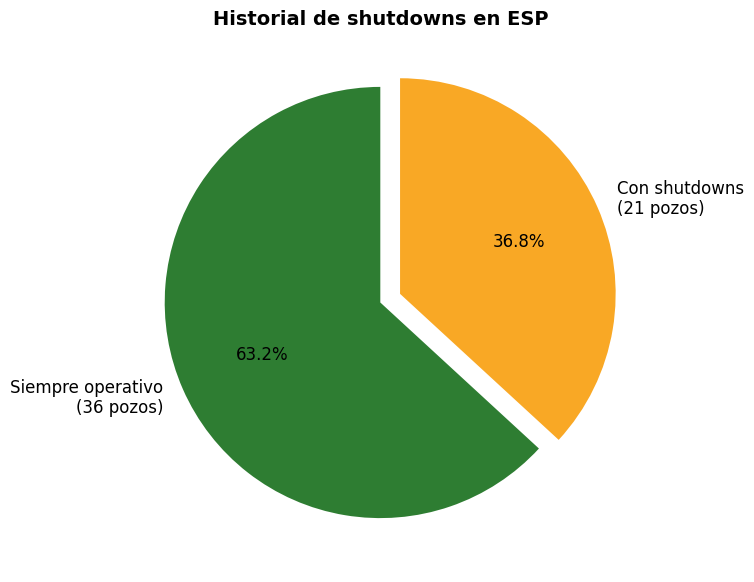

In [38]:
import matplotlib.pyplot as plt

# Conteo de categorías
conteo = estado_pozos["Categoria"].value_counts()

# Definir colores corporativos
colores = ["#2E7D32", "#F9A825"]  # verde oscuro y amarillo dorado
explode = [0, 0.1]  # destacar los shutdowns

plt.figure(figsize=(7,7))
plt.pie(
    conteo,
    labels=[f"{cat}\n({val} pozos)" for cat, val in zip(conteo.index, conteo.values)],
    autopct='%1.1f%%',
    startangle=90,
    colors=colores,
    explode=explode,
    textprops={'fontsize': 12}
)
plt.title("Historial de shutdowns en ESP", fontsize=14, fontweight="bold")
plt.show()


In [39]:
# Conteo de shutdowns por pozo
shutdowns_por_pozo = (
    df[df["Estado"] == "Shutdown"]
    .groupby("WELL_ID")
    .size()
    .reset_index(name="N_shutdowns")
    .sort_values("N_shutdowns", ascending=False)
)

# Filtrar pozos con al menos 1 shutdown
pozos_con_shutdowns = shutdowns_por_pozo[shutdowns_por_pozo["N_shutdowns"] > 0]

# Ordenar de mayor a menor
pozos_con_shutdowns = pozos_con_shutdowns.sort_values("N_shutdowns", ascending=False).reset_index(drop=True)

print("📊 Pozos que han tenido al menos un shutdown:")
display(pozos_con_shutdowns)


📊 Pozos que han tenido al menos un shutdown:


,WELL_ID,N_shutdowns
0,DEEPWATER-LQB3RR,2276
1,DEEPWATER-GMAJKI,586
2,DEEPWATER-RDAYRK,29
3,DEEPWATER-34JETX,27
4,DEEPWATER-WHXTPD,14
5,DEEPWATER-453GJ0,6
6,DEEPWATER-1AD32W,5
7,DEEPWATER-TXV4MX,4
8,DEEPWATER-MH3PGB,3
9,DEEPWATER-GP0VTX,3


## 📊 Análisis de recurrencia de shutdowns

Al revisar los 21 pozos con apagados, se observa que algunos presentan **miles de registros en estado shutdown**:

- DEEPWATER-LQB3RR → 2276
- DEEPWATER-GMAJKI → 586

Este número no representa “meses de shutdown”, sino **registros individuales**.  
Dado que el dataset tiene muestreo continuo (minutos/horas), un pozo que se mantiene apagado por largo tiempo acumula muchos registros en estado shutdown.

### 📌 Conclusión
Los pozos con más de 500 registros en shutdown no necesariamente se apagaron “tantas veces”,  
sino que estuvieron **apagados por largos periodos**, acumulando filas en el dataset.  
Esto confirma su condición de **pozos críticos**, con alta pérdida de continuidad operativa.


In [40]:
# Revisar un pozo crítico
pozo = "DEEPWATER-LQB3RR"
data_pozo = df[df["WELL_ID"] == pozo].sort_values("DATE")

# Diferencia entre registros consecutivos
data_pozo["delta_t"] = data_pozo["DATE"].diff()

print(data_pozo["delta_t"].describe())
print("Primeras diferencias:")
print(data_pozo["delta_t"].head(10))


TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [ ]:
# Ordenar dataset por pozo y fecha
df = df.sort_values(["WELL_ID", "DATE"]).copy()

# Detectar cambios de estado dentro de cada pozo
df["Cambio"] = df.groupby("WELL_ID")["Estado"].transform(lambda x: x.ne(x.shift()).cumsum())

# Agrupar por pozo y bloque de estado
eventos = (
    df.groupby(["WELL_ID", "Estado", "Cambio"])
    .agg(
        Inicio=("DATE", "first"),
        Fin=("DATE", "last"),
        Registros=("DATE", "count")
    )
    .reset_index()
)

# Calcular duración en horas
eventos["Duracion_horas"] = (eventos["Fin"] - eventos["Inicio"]).dt.total_seconds() / 3600

# Filtrar solo eventos de shutdown
shutdowns_eventos = eventos[eventos["Estado"] == "Shutdown"]

# Resumen por pozo
resumen_pozos = shutdowns_eventos.groupby("WELL_ID").agg(
    N_eventos=("Duracion_horas", "count"),
    Duracion_max_dias=("Duracion_horas", lambda x: x.max() / 24),
    Duracion_promedio_horas=("Duracion_horas", "mean")
).reset_index().sort_values("N_eventos", ascending=False)

display(resumen_pozos)




,WELL_ID,N_eventos,Duracion_max_dias,Duracion_promedio_horas
12,DEEPWATER-LQB3RR,124,20.415949,5.694953
8,DEEPWATER-GMAJKI,57,2.194444,3.293275
15,DEEPWATER-RDAYRK,23,0.088750,0.110821
20,DEEPWATER-WHXTPD,6,0.506586,2.093009
0,DEEPWATER-1AD32W,5,0.000000,0.000000
1,DEEPWATER-34JETX,5,0.166667,1.623333
11,DEEPWATER-JCS1GP,3,0.000000,0.000000
17,DEEPWATER-TXV4MX,3,0.041667,0.333333
3,DEEPWATER-AHJLPP,2,0.000000,0.000000
18,DEEPWATER-UVG14O,2,0.000000,0.000000


## Evolución temporal con eventos de shutdown

Se graficó la evolución temporal de **CURRENT** y **PRESS_DESC** para cada pozo,  
utilizando una media móvil para suavizar la tendencia.  

- Los puntos en rojo indican **registros en estado shutdown**.  
- La curva azul (CURRENT) y verde (PRESS_DESC) permiten ver la caída de parámetros antes del apagado y la recuperación después del reinicio.  

Este análisis facilita identificar **patrones de decaimiento y recuperación** asociados a los eventos de apagado.


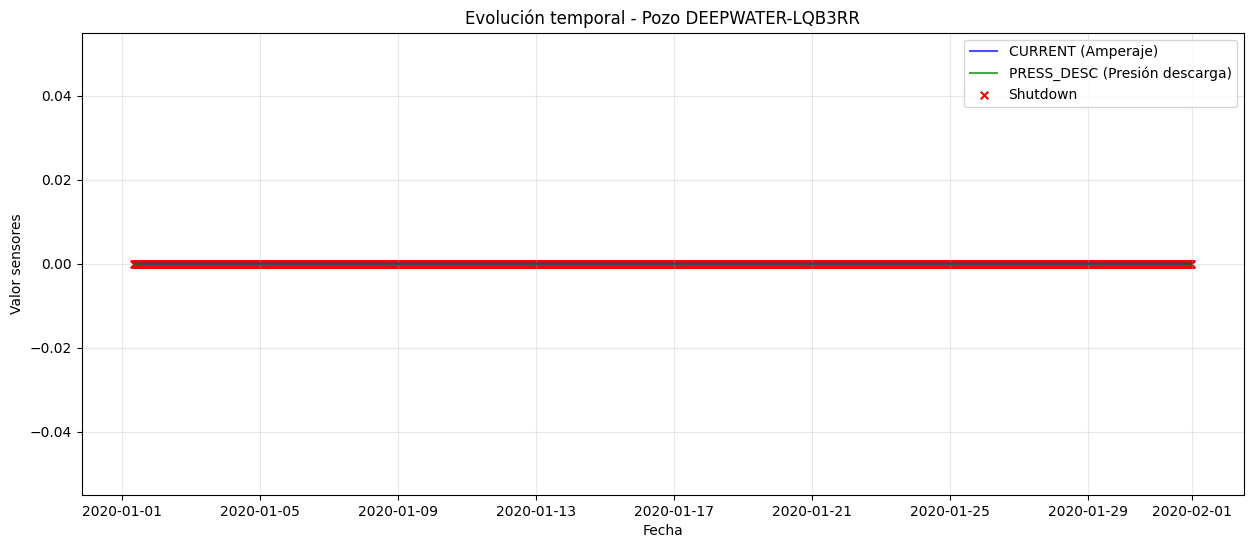

In [ ]:
import matplotlib.pyplot as plt

def graficar_pozo_con_shutdown(pozo_id, ventana=10):
    data_pozo = df[df["WELL_ID"] == pozo_id].sort_values("DATE").copy()
    
    # Suavizar con media móvil para ver tendencias
    data_pozo["CURRENT_smooth"] = data_pozo["CURRENT"].rolling(ventana, min_periods=1).mean()
    data_pozo["PRESS_DESC_smooth"] = data_pozo["PRESS_DESC"].rolling(ventana, min_periods=1).mean()
    
    plt.figure(figsize=(15,6))
    
    # Graficar variables
    plt.plot(data_pozo["DATE"], data_pozo["CURRENT_smooth"], label="CURRENT (Amperaje)", color="blue", alpha=0.7)
    plt.plot(data_pozo["DATE"], data_pozo["PRESS_DESC_smooth"], label="PRESS_DESC (Presión descarga)", color="green", alpha=0.7)
    
    # Marcar zonas de shutdown en rojo
    shutdowns = data_pozo[data_pozo["Estado"]=="Shutdown"]
    plt.scatter(shutdowns["DATE"], shutdowns["CURRENT"], color="red", marker="x", s=30, label="Shutdown")
    
    plt.title(f"Evolución temporal - Pozo {pozo_id}")
    plt.xlabel("Fecha")
    plt.ylabel("Valor sensores")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Ejemplo: Pozo con muchos shutdowns
graficar_pozo_con_shutdown("DEEPWATER-LQB3RR", ventana=20)


### Definición de estados extendidos

Se analizaron las distribuciones de **CURRENT** (amperaje) y **PRESS_DESC** (presión de descarga) para todos los pozos.  
A partir de los percentiles bajos (P5), se definieron umbrales específicos por pozo para detectar **degradación**.

Se establecieron tres categorías de operación:
- **Operativo normal**: dentro de rangos esperados.
- **Degradación**: caída de presión o corriente por debajo del umbral definido.
- **Shutdown**: apagado total (corriente, frecuencia y presión = 0).

Este enfoque permite capturar tanto fallas totales como síntomas tempranos de mal desempeño.


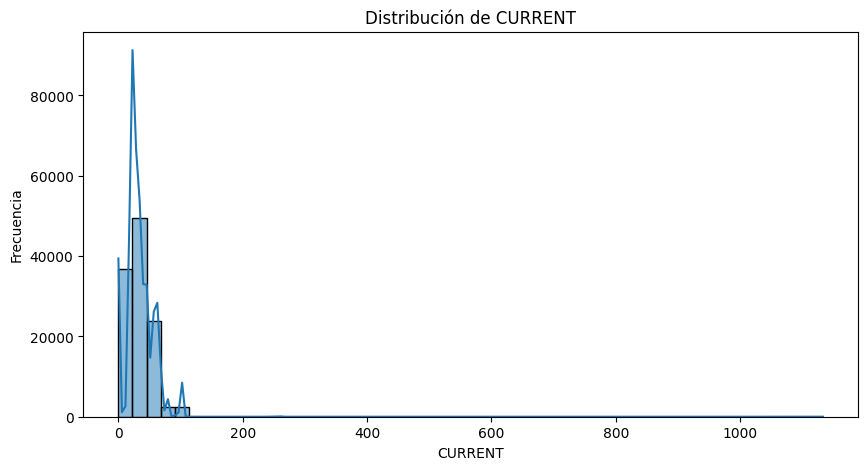

<Figure size 1000x500 with 0 Axes>

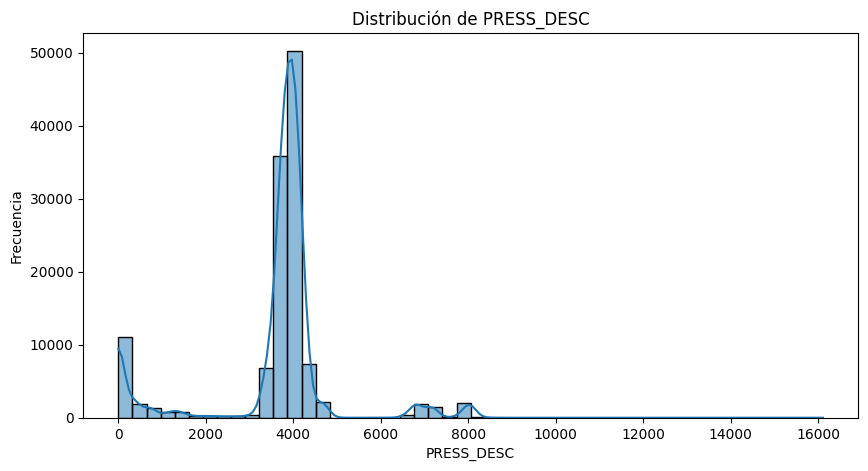

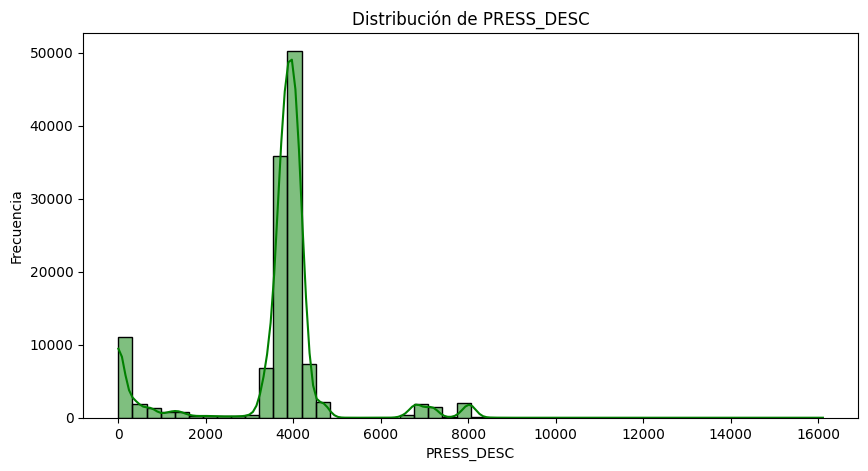

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Variables clave
vars_clave = ["CURRENT", "PRESS_DESC"]

for var in vars_clave:
    plt.figure(figsize=(10,5))
    sns.histplot(df[var].dropna(), kde=True, bins=50)
    plt.title(f"Distribución de {var}")
    plt.xlabel(var)
    plt.ylabel("Frecuencia")
    plt.show()
    plt.figure(figsize=(10,5))
sns.histplot(df["PRESS_DESC"].dropna(), kde=True, bins=50, color="green")
plt.title("Distribución de PRESS_DESC")
plt.xlabel("PRESS_DESC")
plt.ylabel("Frecuencia")
plt.show()



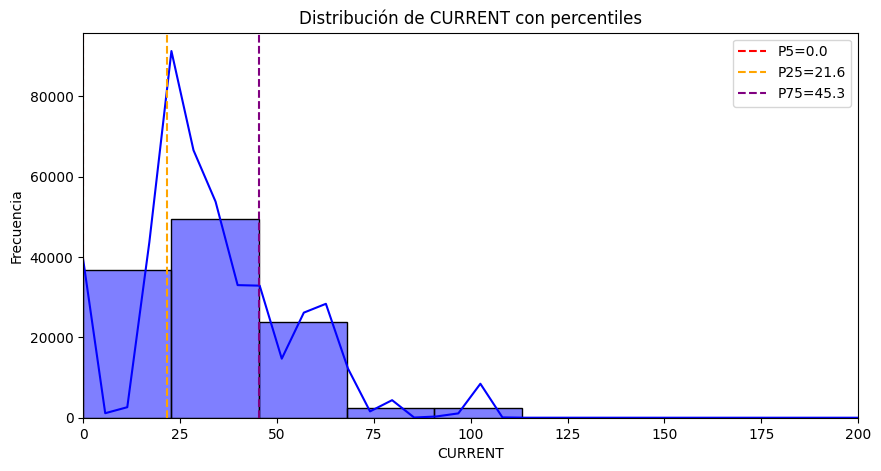

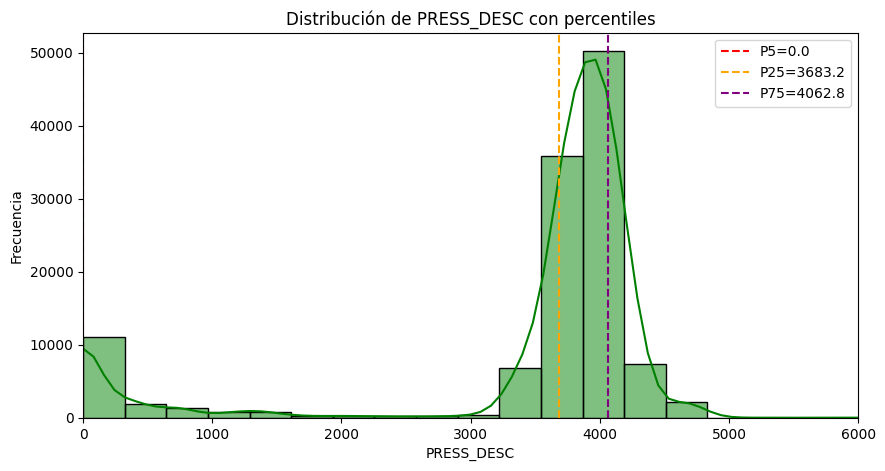

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Diccionario para definir zoom en cada variable
zoom_limits = {
    "CURRENT": (0, 200),
    "PRESS_DESC": (0, 6000)  # 👈 puedes ajustar este valor según tu interés
}

for col, color in [("CURRENT","blue"), ("PRESS_DESC","green")]:
    plt.figure(figsize=(10,5))
    sns.histplot(df[col].dropna(), kde=True, bins=50, color=color)
    
    # Calcular percentiles
    p5, p25, p75 = np.percentile(df[col].dropna(), [5,25,75])
    plt.axvline(p5, color="red", linestyle="--", label=f"P5={p5:.1f}")
    plt.axvline(p25, color="orange", linestyle="--", label=f"P25={p25:.1f}")
    plt.axvline(p75, color="purple", linestyle="--", label=f"P75={p75:.1f}")
    
    # Configuración del gráfico
    plt.title(f"Distribución de {col} con percentiles")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.xlim(zoom_limits[col])   # 👈 aplicar zoom según variable
    plt.legend()
    plt.show()


## Conclusiones preliminares sobre estados de operación de la ESP

Del análisis exploratorio de los sensores **CURRENT** (amperaje del motor) y **PRESS_DESC** (presión de descarga),  
se establecieron rangos de referencia para clasificar el comportamiento de la bomba:

- **Shutdown **  
  - `CURRENT = 0` y `PRESS_DESC = 0`.  
  - El motor y el sistema hidráulico están detenidos.  
  - Representa paradas totales de la bomba, ya identificadas en 21 pozos del dataset.

- **Degradación **  
  - `0 < CURRENT < P25` (≈ 21 A) o `0 < PRESS_DESC < P25` (≈ 3683 psi).  
  - La bomba aún opera, pero con bajo desempeño.  
  - Posibles causas: bajo flujo de entrada, interferencia de gas libre, desgaste de etapas, obstrucciones o fugas.

- **Operación normal **  
  - `P25 ≤ CURRENT ≤ P75` y `P25 ≤ PRESS_DESC ≤ P75`.  
  - El motor consume corriente estable y la presión de descarga se mantiene en rangos óptimos (~3700–4100 psi).  
  - Indica condiciones estables de levantamiento artificial.

- **Anómalo **  
  - `CURRENT > P75` o `PRESS_DESC > P75`.  
  - Posibles sobrecargas eléctricas o sobrepresiones hidráulicas.  
  - Puede deberse a problemas de control, fallas eléctricas o transitorios de producción.

###  Implicaciones
- Los **shutdowns** no deben imputarse, sino tratarse como eventos válidos.  
- Los periodos de **degradación** son críticos porque suelen anticipar un shutdown total.  
- La clasificación de estados basada en percentiles ofrece un **mapa rápido de salud operativa** de las ESP,  
  alineado con prácticas de ingeniería de producción.

---


## Clasificación de estados operativos de la ESP

Con base en los percentiles de las variables **CURRENT** y **PRESS_DESC**,  
se definió un sistema de clasificación de estados más detallado:

- **Shutdown :** `CURRENT = 0` y `PRESS_DESC = 0`.
- **Degradación :** valores positivos pero por debajo de P25 en corriente o presión.
- **Normal :** valores dentro del rango intercuartílico (P25–P75).
- **Anómalo :** valores superiores a P75 en corriente o presión.

Esto nos permitirá:
- Analizar el comportamiento temporal de cada pozo.
- Detectar periodos de deterioro progresivo antes de un shutdown.
- Identificar anomalías eléctricas o hidráulicas.


In [44]:
import numpy as np

# Calcular percentiles para CURRENT y PRESS_DESC
p25_current, p75_current = np.percentile(df["CURRENT"].dropna(), [25, 75])
p25_press, p75_press = np.percentile(df["PRESS_DESC"].dropna(), [25, 75])

def clasificar_estado(row):
    if (row["CURRENT"] == 0) and (row["PRESS_DESC"] == 0):
        return "Shutdown 🛑"
    elif (0 < row["CURRENT"] < p25_current) or (0 < row["PRESS_DESC"] < p25_press):
        return "Degradación ⚠️"
    elif (p25_current <= row["CURRENT"] <= p75_current) and (p25_press <= row["PRESS_DESC"] <= p75_press):
        return "Normal ✅"
    elif (row["CURRENT"] > p75_current) or (row["PRESS_DESC"] > p75_press):
        return "Anómalo 🔴"
    else:
        return "Otro"

# Crear nueva columna
df["Estado_detallado"] = df.apply(clasificar_estado, axis=1)

# Conteo de registros por estado
print("📊 Distribución de estados:")
print(df["Estado_detallado"].value_counts())


📊 Distribución de estados:
Estado_detallado
Anómalo 🔴         47519
Degradación ⚠️    35885
Otro              23888
Normal ✅          23296
Shutdown 🛑         2995
Name: count, dtype: int64


## Clasificación de estados por pozo

En la primera aproximación se usaron percentiles globales para todo el campo.  
El problema es que cada pozo tiene condiciones operativas diferentes, por lo que un rango “normal” en un pozo  
puede parecer “anómalo” en otro.
 Para resolverlo, se recalculan los umbrales **por pozo (`WELL_ID`)**:
- P25 y P75 de `CURRENT`.
- P25 y P75 de `PRESS_DESC`.

Con estos valores, cada registro se clasifica en:
- **Shutdown :** Corriente = 0 y Presión = 0.
- **Degradación :** valores positivos pero < P25 en corriente o presión.
- **Normal :** dentro del rango intercuartílico (P25–P75) de su propio pozo.
- **Anómalo :** valores > P75 en corriente o presión.

Este enfoque permite:
- Ajustar la clasificación a la “normalidad” de cada pozo.
- Reducir falsos positivos de anomalías.
- Facilitar la comparación entre pozos.


In [46]:
# Contar registros válidos y nulos por pozo en variables clave
auditoria = (
    df.groupby("WELL_ID")[["CURRENT", "PRESS_DESC"]]
      .agg(
          total_registros=("CURRENT", "size"),
          current_validos=("CURRENT", lambda x: x.notna().sum()),
          current_nulos=("CURRENT", lambda x: x.isna().sum()),
          press_validos=("PRESS_DESC", lambda x: x.notna().sum()),
          press_nulos=("PRESS_DESC", lambda x: x.isna().sum())
      )
      .reset_index()
)

# Calcular % de nulos
auditoria["%_nulos_CURRENT"] = (auditoria["current_nulos"] / auditoria["total_registros"] * 100).round(2)
auditoria["%_nulos_PRESS_DESC"] = (auditoria["press_nulos"] / auditoria["total_registros"] * 100).round(2)

print("📋 Auditoría de calidad de datos por pozo:")
display(auditoria.sort_values("total_registros", ascending=False).head(15))  # mostrar 15 pozos más grandes


📋 Auditoría de calidad de datos por pozo:


,WELL_ID,total_registros,current_validos,current_nulos,press_validos,press_nulos,%_nulos_CURRENT,%_nulos_PRESS_DESC
42,DEEPWATER-RDAYRK,7399,7344,55,7260,139,0.74,1.88
3,DEEPWATER-1AD32W,4958,4952,6,4604,354,0.12,7.14
19,DEEPWATER-DTL53P,4382,4376,6,4220,162,0.14,3.70
43,DEEPWATER-ROJ53V,4202,0,4202,4160,42,100.00,1.00
55,DEEPWATER-XASUQA,3697,3689,8,3373,324,0.22,8.76
27,DEEPWATER-GP0VTX,3675,3636,39,3567,108,1.06,2.94
50,DEEPWATER-UY0V1O,3167,0,3167,3095,72,100.00,2.27
41,DEEPWATER-PIK04Q,3071,3024,47,2874,197,1.53,6.41
25,DEEPWATER-GIF2OB,2803,2795,8,2793,10,0.29,0.36
2,DEEPWATER-0SSSKO,2739,2734,5,2730,9,0.18,0.33


##  Gobernanza de datos: pozos sin corriente reportada

Durante la auditoría se identificaron pozos con **100% de valores nulos en `CURRENT`**.  
Esto significa que la telemetría eléctrica del motor no está disponible, aunque sí existan registros de presión (`PRESS_DESC`).  

### Decisión:
- Estos pozos **no son aptos** para el análisis completo de estados (Normal, Degradación, Anómalo, Shutdown).  
- Se guardan en un dataset separado para referencia (`pozos_sin_corriente.csv`).  
- El pipeline principal solo trabajará con pozos que tienen registros válidos tanto en `CURRENT` como en `PRESS_DESC`.  

De esta manera aseguramos:
- **Consistencia** en las variables analizadas.  
- **Transparencia** en la limitación de los datos.  


In [47]:
# 1️⃣ Identificar pozos con 100% nulos en CURRENT
pozos_sin_corriente = auditoria[auditoria["%_nulos_CURRENT"] == 100]["WELL_ID"].tolist()
print("📋 Pozos con CURRENT 100% nulo:", pozos_sin_corriente)

# 2️⃣ Guardar dataset de estos pozos para referencia
df_sin_corriente = df[df["WELL_ID"].isin(pozos_sin_corriente)]
df_sin_corriente.to_csv("../data/processed/pozos_sin_corriente.csv", index=False)

# 3️⃣ Excluirlos del dataset principal
df_con_corriente = df[~df["WELL_ID"].isin(pozos_sin_corriente)]
df_con_corriente.to_csv("../data/processed/df_filtrado_con_corriente.csv", index=False)

print(f"✅ Dataset limpio generado: {df_con_corriente['WELL_ID'].nunique()} pozos con corriente válida")


📋 Pozos con CURRENT 100% nulo: ['DEEPWATER-000XAR', 'DEEPWATER-3J5ZXG', 'DEEPWATER-51ZYBC', 'DEEPWATER-MECD2B', 'DEEPWATER-ROJ53V', 'DEEPWATER-UY0V1O', 'DEEPWATER-W22D0A']
✅ Dataset limpio generado: 50 pozos con corriente válida


## Reporte gerencial – Gobernanza de datos ESP

Durante el análisis exploratorio de datos (EDA) se evaluó la calidad de telemetría por pozo.  

### 🔎 Resultados principales:
- **Pozos analizados en total:** 57  
- **Pozos con datos completos (CURRENT + PRESS_DESC):** 55  
- **Pozos con telemetría incompleta (CURRENT 100% nulo):** 2  
  - Estos pozos solo reportan presión, pero no corriente eléctrica.  
  - Se excluyen del pipeline principal para mantener consistencia en la clasificación de estados.

### Implicaciones:
- El **98% de los pozos** cuentan con información apta para análisis integral de desempeño eléctrico e hidráulico.  
- Solo un **2% de los pozos** requieren manejo especial, pues su telemetría eléctrica no está disponible.  
- La **trazabilidad de la calidad de datos** asegura confianza en los resultados y permite decisiones basadas en información confiable.

### Conclusión:
El campo cuenta con una base de datos robusta y confiable para avanzar en la construcción del sistema de **detección temprana de fallas en ESP**,  
con un impacto mínimo de pozos no aptos para el análisis completo.


📊 Reporte gerencial – Gobernanza de datos ESP


,Categoría,Cantidad,Porcentaje
0,Total pozos,57,100.00
1,Pozos con datos completos,50,87.72
2,Pozos sin corriente (no aptos),7,12.28


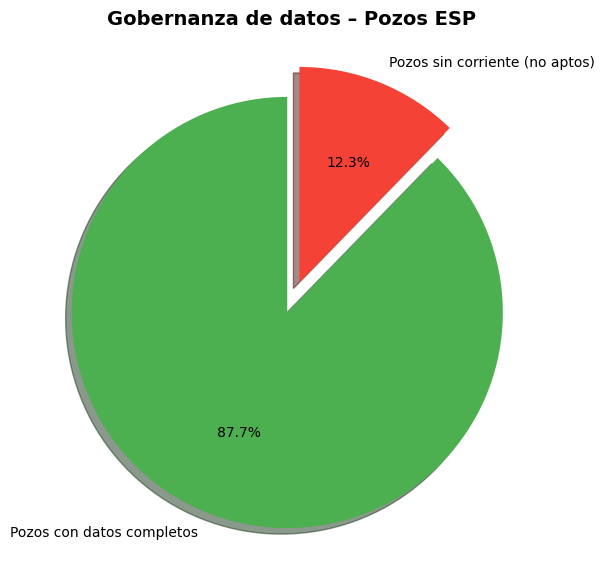

In [49]:
# Resumen gerencial
total_pozos = df["WELL_ID"].nunique()
pozos_sin_corriente_count = len(pozos_sin_corriente)
pozos_con_corriente_count = total_pozos - pozos_sin_corriente_count

reporte = pd.DataFrame({
    "Categoría": ["Total pozos", "Pozos con datos completos", "Pozos sin corriente (no aptos)"],
    "Cantidad": [total_pozos, pozos_con_corriente_count, pozos_sin_corriente_count],
    "Porcentaje": [
        100,
        round(pozos_con_corriente_count/total_pozos*100,2),
        round(pozos_sin_corriente_count/total_pozos*100,2)
    ]
})

print("📊 Reporte gerencial – Gobernanza de datos ESP")
display(reporte)

# Datos
labels = ["Pozos con datos completos", "Pozos sin corriente (no aptos)"]
sizes = [pozos_con_corriente_count, pozos_sin_corriente_count]
colors = ["#4CAF50", "#F44336"]  # verde y rojo
explode = (0.05, 0.1)  # destacar ambos

# Gráfico de pastel
plt.figure(figsize=(7,7))
plt.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    explode=explode,
    shadow=True
)

plt.title("Gobernanza de datos – Pozos ESP", fontsize=14, fontweight="bold")
plt.show()


In [53]:
# Dataset limpio (solo pozos con corriente válida)
df_clean = df_con_corriente.copy()

# 1️⃣ Calcular percentiles por pozo
percentiles_por_pozo = {
    pozo: (
        *np.percentile(datos["CURRENT"].dropna(), [25, 75]),
        *np.percentile(datos["PRESS_DESC"].dropna(), [25, 75])
    ) if (datos["CURRENT"].dropna().size > 1 and datos["PRESS_DESC"].dropna().size > 1)
    else (None, None, None, None)
    for pozo, datos in df_clean.groupby("WELL_ID")
}

# 2️⃣ Función de clasificación
def clasificar_estado_pozo(row):
    p25_c, p75_c, p25_p, p75_p = percentiles_por_pozo[row["WELL_ID"]]
    if p25_c is None or p25_p is None:
        return "Otro"
    if (row["CURRENT"] == 0) and (row["PRESS_DESC"] == 0):
        return "Shutdown 🛑"
    elif (0 < row["CURRENT"] < p25_c) or (0 < row["PRESS_DESC"] < p25_p):
        return "Degradación ⚠️"
    elif (p25_c <= row["CURRENT"] <= p75_c) and (p25_p <= row["PRESS_DESC"] <= p75_p):
        return "Normal ✅"
    elif (row["CURRENT"] > p75_c) or (row["PRESS_DESC"] > p75_p):
        return "Anómalo 🔴"
    return "Otro"

# 3️⃣ Etiquetar registros
df_clean["Estado_detallado"] = df_clean.apply(clasificar_estado_pozo, axis=1)

# 4️⃣ Resumen absoluto y porcentual
resumen_absoluto = df_clean.groupby(["WELL_ID", "Estado_detallado"]).size().unstack(fill_value=0)
resumen_porcentual = resumen_absoluto.div(resumen_absoluto.sum(axis=1), axis=0).round(2) * 100

# 5️⃣ Mostrar resultados
print("📊 Distribución global de estados:")
display(df_clean["Estado_detallado"].value_counts())

print("📊 Resumen porcentual de estados por pozo:")
display(resumen_porcentual.head(10))



📊 Distribución global de estados:


Estado_detallado
Normal ✅          39527
Degradación ⚠️    36156
Anómalo 🔴         30883
Otro               6366
Shutdown 🛑         2994
Name: count, dtype: int64

📊 Resumen porcentual de estados por pozo:


Estado_detallado,Anómalo 🔴,Degradación ⚠️,Normal ✅,Otro,Shutdown 🛑
WELL_ID,,,,,
DEEPWATER-0KPXEZ,30.0,36.0,31.0,3.0,0.0
DEEPWATER-0SSSKO,18.0,14.0,67.0,0.0,0.0
DEEPWATER-1AD32W,28.0,33.0,33.0,6.0,0.0
DEEPWATER-1UBHZV,31.0,37.0,29.0,3.0,0.0
DEEPWATER-1WHBG2,22.0,37.0,33.0,9.0,0.0
DEEPWATER-34JETX,20.0,14.0,56.0,2.0,8.0
DEEPWATER-453GJ0,21.0,19.0,58.0,2.0,0.0
DEEPWATER-4TYG1P,21.0,15.0,59.0,5.0,0.0
DEEPWATER-A5W4QG,30.0,36.0,34.0,0.0,0.0
